In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..'))) # Sube un nivel si el notebook está en una subcarpeta

Original p-value: 0.765479
FracDiff p-value: 0.057248


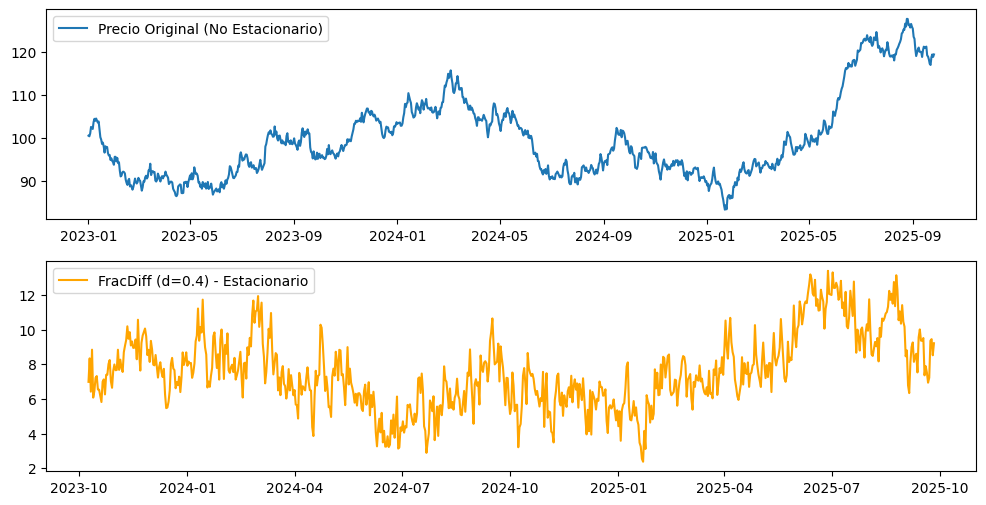

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neural_risk.data.data_processor import RiskCleaner

# 1. Simulación de datos
np.random.seed(42)
fechas = pd.date_range(start='2023-01-01', periods=1000)
precios = np.cumsum(np.random.randn(1000)) + 100
df = pd.DataFrame({'Close': precios}, index=fechas)

# 2. Limpieza
cleaner = RiskCleaner()
df_clean = cleaner.auto_clean(df)

# 3. FracDiff (López de Prado)
# Probamos con d=0.4. Si el p-value es > 0.05, subimos d a 0.5 o 0.6
d_val = 0.4
df_frac = cleaner.fractional_diff(df_clean['Close'], d=d_val, thres=1e-4)

# 4. Verificación de Estacionariedad
stat_orig = cleaner.check_stationarity(df_clean['Close'])
stat_frac = cleaner.check_stationarity(df_frac)

print(f"Original p-value: {stat_orig.get('p_value', 'Error')}")
print(f"FracDiff p-value: {stat_frac.get('p_value', 'Error')}")

# 5. Visualización (La ventaja del Notebook)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df_clean['Close'], label='Precio Original (No Estacionario)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(df_frac, label=f'FracDiff (d={d_val}) - Estacionario', color='orange')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from neural_risk.data.data_processor import RiskCleaner

cleaner = RiskCleaner()

# 1. Generador de Datos Sintéticos
def generate_synthetic_data(name, start="2024-01-01", periods=100, freq='D', vol=0.02):
    dates = pd.date_range(start=start, periods=periods, freq=freq)
    # Simulamos un Random Walk: P_t = P_{t-1} * exp(e)
    returns = np.random.normal(0, vol, periods)
    prices = 100 * np.exp(np.cumsum(returns))
    df = pd.DataFrame({'Close': prices, 'Volume': np.random.randint(1000, 5000, periods)}, index=dates)
    return cleaner.rename_columns(df, name)

# 2. Creamos un activo de 'Bolsa' (solo días hábiles) y una 'Crypto' (7 días a la semana)
df_stock = generate_synthetic_data("STOCK", periods=20, freq='B') # Business days
df_crypto = generate_synthetic_data("CRYPTO", periods=28, freq='D') # Calendar days

# 3. Normalización y Merge
# Estandarizamos zona horaria
df_stock = cleaner.standardize_timezone(df_stock)
df_crypto = cleaner.standardize_timezone(df_crypto)

# Merge con FFill: El STOCK tomará el valor del viernes durante el sábado y domingo
portfolio = cleaner.merge_datasets([df_stock, df_crypto], ffill=True)

# 4. Cálculo de Retornos y Limpieza de Outliers
returns = cleaner.get_returns(portfolio, columns=['STOCK_Close', 'CRYPTO_Close'])
returns_no_outliers = cleaner.handle_outliers(returns)

print("--- Portfolio Head (Merge & FFill) ---")
print(portfolio.head(10))

print("\n--- Retornos Logarítmicos ---")
print(returns_no_outliers.head())

--- Portfolio Head (Merge & FFill) ---
                           STOCK_Close  STOCK_Volume  CRYPTO_Close  \
2024-01-01 00:00:00+00:00   102.838243        4638.0    100.076036   
2024-01-02 00:00:00+00:00   104.757690        1749.0    100.316570   
2024-01-03 00:00:00+00:00   104.882699        4427.0    101.555073   
2024-01-04 00:00:00+00:00   103.534391        1684.0     99.498781   
2024-01-05 00:00:00+00:00   104.990336        2927.0     98.987924   
2024-01-06 00:00:00+00:00   104.990336        2927.0     95.739042   
2024-01-07 00:00:00+00:00   104.990336        2927.0     96.506527   
2024-01-08 00:00:00+00:00   105.819839        4804.0     97.763819   
2024-01-09 00:00:00+00:00   107.731485        4702.0     96.823606   
2024-01-10 00:00:00+00:00   109.108774        3356.0     99.920070   

                           CRYPTO_Volume  
2024-01-01 00:00:00+00:00           2622  
2024-01-02 00:00:00+00:00           4369  
2024-01-03 00:00:00+00:00           1939  
2024-01-04 00:00:0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neural_risk.data.data_processor import RiskCleaner
from neural_risk.data.feature_engineering import RiskFeaturePipeline
from neural_risk.data.labeling import RiskLabeler

cleaner = RiskCleaner()

def generate_synthetic_ohlcv(name, start="2024-01-01", periods=1000, vol=0.02):
    """Genera datos OHLCV realistas para testing de volatilidad."""
    np.random.seed(42) # Para que siempre obtengamos los mismos resultados
    dates = pd.date_range(start=start, periods=periods, freq='D')
    
    # Random walk para el Close
    returns = np.random.normal(0, vol, periods)
    close = 100 * np.exp(np.cumsum(returns))
    
    df = pd.DataFrame(index=dates)
    df['Open'] = close * (1 + np.random.normal(0, 0.002, periods))
    df['Close'] = close
    
    # High y Low basados en volatilidad intradía
    high_noise = np.abs(np.random.normal(0, vol/1.5, periods))
    low_noise = np.abs(np.random.normal(0, vol/1.5, periods))
    df['High'] = df[['Open', 'Close']].max(axis=1) * (1 + high_noise)
    df['Low'] = df[['Open', 'Close']].min(axis=1) * (1 - low_noise)
    df['Volume'] = np.random.randint(10000, 50000, periods)
    
    return cleaner.rename_columns(df, name)

--- Pipeline Result ---
Columnas generadas: ['SPY_Open', 'SPY_Close', 'SPY_High', 'SPY_Low', 'SPY_Volume', 'BTC_Open', 'BTC_Close', 'BTC_High', 'BTC_Low', 'BTC_Volume', 'SPY_asym_vol', 'SPY_parkinson_gap', 'SPY_vol_adj_kurt', 'BTC_asym_vol', 'BTC_parkinson_gap', 'BTC_vol_adj_kurt', 'target_vol_jump']
Eventos de riesgo detectados: 107 de 960 días.


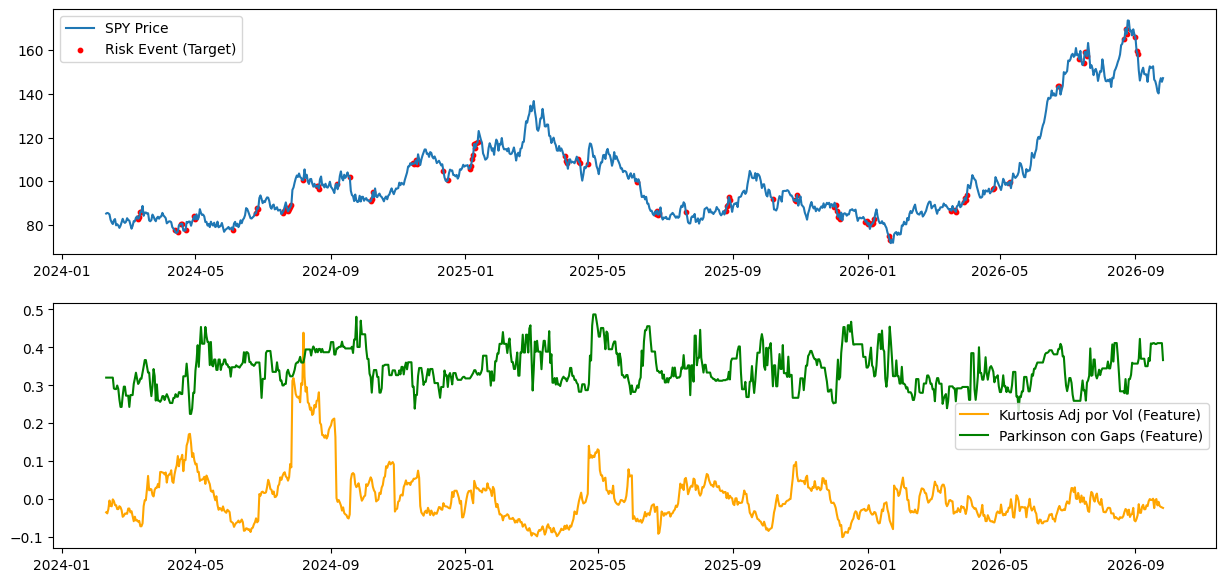

In [17]:
# 1. Ingesta de datos sintéticos (Simulamos 2 activos)
df_spy = generate_synthetic_ohlcv("SPY")
df_btc = generate_synthetic_ohlcv("BTC", vol=0.05) # BTC es más volátil

# 2. Merge y Limpieza (Normalización de Cartera)
portfolio = cleaner.merge_datasets([df_spy, df_btc])

# 3. Feature Engineering (Aquí usamos las 3 clases de Volatilidad avanzada)
pipeline = RiskFeaturePipeline()
# El pipeline ya sabe buscar High, Low, Open, etc. con el prefijo
full_data = pipeline.transform(portfolio, asset_names=['SPY', 'BTC'])

# 4. Labeling (El Target que el modelo de ML intentará predecir)
# Vamos a etiquetar saltos de volatilidad en el SPY (Anomalías de riesgo)
labeler = RiskLabeler()
full_data['target_vol_jump'] = labeler.label_volatility_jump(full_data['SPY_Close'], threshold_std=1.5)

print("--- Pipeline Result ---")
print(f"Columnas generadas: {full_data.columns.tolist()}")
print(f"Eventos de riesgo detectados: {full_data['target_vol_jump'].sum()} de {len(full_data)} días.")

# 5. Visualización de Verificación
plt.figure(figsize=(15, 7))
plt.subplot(2,1,1)
plt.plot(full_data['SPY_Close'], label='SPY Price')
# Pintamos de rojo donde el Labeler detectó un salto de riesgo futuro
plt.scatter(full_data.index[full_data['target_vol_jump']==1], 
            full_data['SPY_Close'][full_data['target_vol_jump']==1], 
            color='red', label='Risk Event (Target)', s=10)
plt.legend()

plt.subplot(2,1,2)
plt.plot(full_data['SPY_vol_adj_kurt'], label='Kurtosis Adj por Vol (Feature)', color='orange')
plt.plot(full_data['SPY_parkinson_gap'], label='Parkinson con Gaps (Feature)', color='green')
plt.legend()
plt.show()

In [18]:
# En tu notebook, después de generar el portfolio sintético:
pipeline = RiskFeaturePipeline()

# Usamos SPY como benchmark para ver cómo se correlaciona BTC
full_data = pipeline.transform(portfolio, asset_names=['SPY', 'BTC'], benchmark_name='SPY')

# Verificamos las nuevas columnas
print(full_data[['BTC_hurst', 'BTC_entropy', 'BTC_momentum_xc']].tail())

TypeError: RiskFeaturePipeline.transform() got an unexpected keyword argument 'benchmark_name'

In [20]:
pipeline = RiskFeaturePipeline()
# Asegurate de pasar al menos 2 activos en la lista
full_data = pipeline.transform(portfolio, asset_names=['SPY', 'BTC'])

# Visualización del Equilibrio
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(full_data['pair_spread'], label='Spread Cointegrado (SPY-BTC)', color='brown')
ax[0].axhline(full_data['pair_spread'].mean(), color='black', linestyle='--')
ax[1].plot(full_data['pair_half_life'], label='Half-Life (Días para volver a la media)', color='blue')
plt.legend()
plt.show()

NameError: name 'InformationalDynamicsFeatures' is not defined

In [23]:
from neural_risk.data.feature_engineering import InformationalDynamicsFeatures
print("Clase cargada con exito")

Clase cargada con exito


In [ ]:
import pandas as pd
import numpy as np
from neural_risk.data.data_processor import RiskCleaner
from neural_risk.data.feature_engineering import RiskFeaturePipeline

def create_test_market_data(periods=1200):
    """
    Crea un dataset sintetico de BTC y SPY con OHLCV completo.
    """
    np.random.seed(42)
    dates = pd.date_range(start="2020-01-01", periods=periods, freq='D')
    cleaner = RiskCleaner()
    
    assets = {
        "BTC": {"vol": 0.04, "drift": 0.001},
        "SPY": {"vol": 0.015, "drift": 0.0005}
    }
    
    data_list = []
    
    for name, params in assets.items():
        # Generamos el Close con un Random Walk
        returns = np.random.normal(params["drift"], params["vol"], periods)
        close = 100 * np.exp(np.cumsum(returns))
        
        # Construimos el OHLCV
        df = pd.DataFrame(index=dates)
        df['Close'] = close
        df['Open'] = df['Close'].shift(1) * (1 + np.random.normal(0, 0.002, periods))
        df['Open'].iloc[0] = df['Close'].iloc[0] * 0.99
        
        # High y Low basados en volatilidad intradia
        df['High'] = df[['Open', 'Close']].max(axis=1) * (1 + np.abs(np.random.normal(0, params["vol"]/2, periods)))
        df['Low'] = df[['Open', 'Close']].min(axis=1) * (1 - np.abs(np.random.normal(0, params["vol"]/2, periods)))
        
        # Volumen con correlacion a la volatilidad (mas vol = mas volumen)
        df['Volume'] = (np.abs(returns) * 1000000 + np.random.randint(10000, 50000, periods)).astype(int)
        
        # Usamos el cleaner de tu lib para renombrar
        df_cleaned = cleaner.rename_columns(df, name)
        data_list.append(df_cleaned)
    
    # Unimos los activos usando tu RiskCleaner
    portfolio_df = cleaner.merge_datasets(data_list)
    return portfolio_df

# --- EJECUCION ---
portfolio = create_test_market_data()
print("¡Data de test creada!")
print(f"Columnas presentes: {portfolio.columns.tolist()}")
print(portfolio.head(3))

C:\Users\LKS\AppData\Local\Temp\ipykernel_17584\3042757103.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Open'].iloc[0] = df['Close'].iloc[0] * 0.99


¡Data de test creada!
Columnas presentes: ['BTC_Close', 'BTC_Open', 'BTC_High', 'BTC_Low', 'BTC_Volume', 'SPY_Close', 'SPY_Open', 'SPY_High', 'SPY_Low', 'SPY_Volume']
             BTC_Close    BTC_Open    BTC_High     BTC_Low  BTC_Volume  \
2020-01-01  102.108784  101.087696  103.582699   99.421901       59268   
2020-01-02  101.647219  102.021092  102.381881  100.185309       26483   
2020-01-03  104.419425  101.672081  105.561105   97.503908       60442   

             SPY_Close    SPY_Open    SPY_High    SPY_Low  SPY_Volume  
2020-01-01  100.006176   99.006114  100.074666  97.968150       46511  
2020-01-02  101.226306  100.037797  101.515147  99.144079       23980  
2020-01-03   99.701002  101.392265  101.871692  99.296111       56740  


C:\Users\LKS\AppData\Local\Temp\ipykernel_17584\3042757103.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Open'].iloc[0] = df['Close'].iloc[0] * 0.99


In [27]:
# Instanciamos tu pipeline
pipeline = RiskFeaturePipeline()

try:
    # Transformamos la data de test
    full_data = pipeline.transform(portfolio, asset_names=['BTC', 'SPY'], benchmark_name='SPY')
    
    print("\n--- TEST EXITOSO ---")
    print(f"Filas resultantes: {len(full_data)}")
    print(f"Nuevas features generadas: {len(full_data.columns) - len(portfolio.columns)}")
    
    # Mostramos algunas de las features mas complejas
    display_cols = [c for c in full_data.columns if 'hurst' in c or 'entropy' in c or 'anomaly' in c]
    print("\nMuestra de features avanzadas:")
    print(full_data[display_cols].tail())

except Exception as e:
    print(f"\n--- ERROR EN EL TEST ---")
    print(f"Detalle: {str(e)}")

f:\quant_risk\neural-risk\neural_risk\data\feature_engineering.py:440: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  
f:\quant_risk\neural-risk\neural_risk\data\feature_engineering.py:440: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  
f:\quant_risk\neural-risk\neural_risk\data\feature_engineering.py:440: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  
f:\quant_risk\neural-risk\neural_risk\data\feature_engineering.py:440: FutureWarni


--- ERROR EN EL TEST ---
Detalle: 1


In [12]:
def generate_synthetic_ohlcv(name, start="2024-01-01", periods=500, freq='D', vol=0.02):
    """
    Genera datos OHLCV realistas para testear features de volatilidad.
    """
    dates = pd.date_range(start=start, periods=periods, freq=freq)
    
    # 1. Generar Close usando Random Walk
    returns = np.random.normal(0, vol, periods)
    close = 100 * np.exp(np.cumsum(returns))
    
    # 2. Generar Open, High, Low basados en el Close
    # Simulamos que el High es un poco más que el max(Open, Close) y el Low un poco menos
    df = pd.DataFrame(index=dates)
    df['Open'] = close.shift(1).fillna(100)
    df['Close'] = close
    
    # Añadimos ruido aleatorio para High y Low
    high_noise = np.abs(np.random.normal(0, vol/2, periods))
    low_noise = np.abs(np.random.normal(0, vol/2, periods))
    
    df['High'] = df[['Open', 'Close']].max(axis=1) * (1 + high_noise)
    df['Low'] = df[['Open', 'Close']].min(axis=1) * (1 - low_noise)
    df['Volume'] = np.random.randint(1000, 5000, periods)
    
    # Renombrar con el prefijo para que el RiskCleaner y el Pipeline lo reconozcan
    return cleaner.rename_columns(df, name)

In [ ]:
import pandas as pd
import numpy as np
from neural_risk.data.data_processor import RiskCleaner
from neural_risk.data.feature_engineering import RiskFeaturePipeline

# 1. Preparar entorno
cleaner = RiskCleaner()
pipeline = RiskFeaturePipeline()

# 2. Generar data sintética (BTC y SPY)
def generate_robust_test_data():
    periods = 1500  # Necesitamos bastantes datos para los HMM
    dates = pd.date_range(start="2020-01-01", periods=periods, freq='D')
    
    data_list = []
    for name, vol in [("BTC", 0.04), ("SPY", 0.015)]:
        # Generar Close con drift
        returns = np.random.normal(0.0005, vol, periods)
        close = 100 * np.exp(np.cumsum(returns))
        
        df = pd.DataFrame(index=dates)
        df['Close'] = close
        df['Open'] = df['Close'].shift(1).fillna(df['Close'] * 0.99)
        df['High'] = df[['Open', 'Close']].max(axis=1) * (1 + np.abs(np.random.normal(0, vol/2, periods)))
        df['Low'] = df[['Open', 'Close']].min(axis=1) * (1 - np.abs(np.random.normal(0, vol/2, periods)))
        df['Volume'] = np.random.randint(10000, 100000, periods)
        
        data_list.append(cleaner.rename_columns(df, name))
    
    return cleaner.merge_datasets(data_list)

# 3. Ejecutar transformación
portfolio = generate_robust_test_data()

try:
    print("Transformando datos... (esto puede tardar unos segundos por los HMM)")
    full_data = pipeline.transform(portfolio, asset_names=['BTC', 'SPY'], benchmark_name='SPY')
    
    print("\n✅ --- PIPELINE FINALIZADO CON EXITO ---")
    print(f"Dimensiones de la matriz: {full_data.shape}")
    
    # Verificación de bloques clave
    key_features = [
        'BTC_hmm_state_0_prob', 'BTC_prob_transition_down', # Markov
        'BTC_rep_cost', 'BTC_path_risk',                   # Sintéticos
        'BTC_centrality', 'pair_half_life'                 # Redes / Cointeg.
    ]
    
    print("\nVerificando presencia de features clave:")
    for feat in key_features:
        status = "OK" if feat in full_data.columns else "MISSING"
        print(f" - {feat}: {status}")

except Exception as e:
    print(f"\n❌ --- ERROR EN EL PIPELINE ---")
    print(f"Detalle técnico: {str(e)}")

Transformando datos... (esto puede tardar unos segundos por los HMM)


f:\quant_risk\neural-risk\neural_risk\data\feature_engineering.py:440: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  
f:\quant_risk\neural-risk\neural_risk\data\feature_engineering.py:440: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  
f:\quant_risk\neural-risk\neural_risk\data\feature_engineering.py:440: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  
f:\quant_risk\neural-risk\neural_risk\data\feature_engineering.py:440: FutureWarni


❌ --- ERROR EN EL PIPELINE ---
Detalle técnico: 1


f:\quant_risk\neural-risk\neural_risk\data\feature_engineering.py:440: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  
f:\quant_risk\neural-risk\neural_risk\data\feature_engineering.py:440: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  
f:\quant_risk\neural-risk\neural_risk\data\feature_engineering.py:440: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  
